#1. Thư viện


In [120]:
pip install pmdarima

In [121]:
import yfinance as yf
import numpy as np
import torch.nn as nn
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


#2. Đọc dữ liệu

In [122]:
# Đọc dữ liệu từ drive
from google.colab import drive
drive.mount('/content/drive')
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/Ky_2_nam_3/DA/bnb.csv')
# df = pd.read_csv('/content/bnb.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335
...,...,...,...,...,...,...,...
1914,2024-05-27,599.825928,613.388184,599.700745,603.526428,603.526428,1691663828
1915,2024-05-28,603.526428,604.985107,593.716187,601.213257,601.213257,1852329404
1916,2024-05-29,601.213257,602.931519,592.966614,594.972046,594.972046,1642696946
1917,2024-05-30,594.972534,601.665039,586.557678,595.026794,595.026794,1737524745


#3. Chia tập dữ liệu

In [124]:
# Chuyển dữ liệu thời gian
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
# # Đảo ngược lại dữ liệu

In [125]:
# DATA VALUE
# Lấy dữ liệu cần phân tích
time_series_Close = df['Close']

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra(6:2:2)
# Kích thước tập dữ liệu (6:2:2)
train_size = int(0.6 * len(time_series_Close))
test_size = int(0.2 * len(time_series_Close))
val_size = int(len(time_series_Close) - train_size - test_size)
# Giá trị tập từ liệu (6:2:2)
train_data = time_series_Close[:train_size]
test_data = time_series_Close[train_size:train_size + test_size]
val_data = time_series_Close[-val_size:]
# Lấy dữ liệu 100 ngày gần nhất
recent_100_Close = time_series_Close[-100:]
# Chuyển đổi dữ liệu 100 ngày gần nhất thành numpy array và mở rộng chiều
recent_100_Close_array = recent_100_Close.values.astype(np.float32)
recent_100_Close_array = np.expand_dims(recent_100_Close_array, axis=0)
recent_100_Close_array = np.expand_dims(recent_100_Close_array, axis=-1)

# DATA DATE
# Lấy dữ liệu Date cần phân tích để dự bảo DL trên tập test và train
time_series_Date = df['Date']

# Tỉ lệ 6:2:2
# Kích thước tập dữ liệu (6:2:2)
train_date_size = int(0.6 * len(time_series_Date))
test_date_size = int(0.2 * len(time_series_Date))
val_date_size= int(len(time_series_Date) - train_date_size - test_date_size)
# Giá trị tập từ liệu (6:2:2)
train_date_data = time_series_Date[:train_date_size]
test_date_data = time_series_Date[train_date_size:train_date_size + test_date_size]
val_date_data = time_series_Date[-val_date_size:]

first_date_Date = test_date_data.min()
first_date_Date_2 = test_date_data.max()

print(first_date_Date)
print(first_date_Date_2)


2022-04-25 00:00:00
2023-05-12 00:00:00


#4. Dự đoán tập test

In [ ]:
auto_arima(train_data, maxiter=100)

ARIMA(maxiter=100, order=(4, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [126]:
model_train = ARIMA(train_data, order=(4, 1, 4))  # Adjust the order as needed
fit_model = model_train.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [127]:
# Series to store model predictions
predictions = test_data.copy() * 0
# Series with last 60 days of prices
history = train_data.copy().iloc[-60:]
for date in test_data.index:
    # Fit model on updated data
    model = ARIMA(history, order=(4,1,4))
    model_res = model.fit(fit_model.params)
    # Make new forecast
    yhat = model_res.forecast()
    predictions.loc[date] = yhat
    history.loc[date] = test_data[date]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [139]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [144]:
# Calculate RMSE
error = mean_squared_error(test_data, predictions)
print("ARIMA Testing RMSE:", error)

# Tính toán RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
error = mean_squared_error(test_data, predictions)

# Tính toán MAE
mae = mean_absolute_error(test_data, predictions)
# Tính toán MAPE
mape = mean_absolute_percentage_error(test_data, predictions)

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)


ARIMA Testing RMSE: 112.31584988440125
RMSE: 10.597917242760543
MAE: 7.229852484945313
MAPE: 2.518337956905432


In [137]:
import numpy as np

def calculate_errors(actual, predicted):
  """
  Calculates RMSE, MAE, and MAPE for time series forecasting.

  Args:
      actual (np.ndarray): Array of actual values.
      predicted (np.ndarray): Array of predicted values.

  Returns:
      dict: Dictionary containing RMSE, MAE, and MAPE values.
  """

  # Ensure arrays have the same length
  actual = actual[:len(predicted)]
  predicted = predicted[:len(actual)]

  # Calculate errors
  rmse = np.sqrt(np.mean((actual - predicted) ** 2))
  mae = np.mean(np.abs(actual - predicted))

  # Handle potential division by zero for MAPE
  if np.all(actual == 0):
    mape = np.nan  # Not applicable for all zeros in actual values
  else:
    mape = np.mean(np.abs((actual - predicted) / actual) * 100)

  return {"RMSE": rmse, "MAE": mae, "MAPE": mape}

# Assuming you have your actual values (test_data_remaining) and predicted values (predictions)

errors = calculate_errors(test_data, predictions)

# Print the calculated errors
print("RMSE:", errors["RMSE"])
print("MAE:", errors["MAE"])
print("MAPE:", errors["MAPE"])


RMSE: 10.597917242760543
MAE: 7.229852484945313
MAPE: 2.518337956905432


# Val

In [129]:
# Window slider
# Example usage:
# Assuming 'data' is your time series data
window_size = 30  # Specify the window size
order = (4, 1, 4)  # Specify the order for ARIMA model
def sliding_window_arima(data, window_size, order):
    # Initialize an empty list to store the predictions
    predictions_val = []

    # Iterate through the time series data using a sliding window
    for i in range(len(val_data) - window_size):
        # Extract the current window of data
        window_data = val_data[i:i+window_size]

        # Fit ARIMA model to the current window of data
        model = ARIMA(window_data, order=order)
        fit_model = model.fit()

        # Make one-step-ahead forecast using the fitted model
        next_day_prediction = fit_model.forecast(steps=1)

        # Append the forecasted value to the predictions list
        predictions_val.append(next_day_prediction)

    return np.array(predictions_val)

# Perform sliding window forecasting with ARIMA
forecasted_values = sliding_window_arima(df, window_size, order)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/s

In [130]:
# Define a range of dates for the forecasted values
forecasted_dates = val_date_data[window_size:]
forecasted_dates

1564   2023-06-12
1565   2023-06-13
1566   2023-06-14
1567   2023-06-15
1568   2023-06-16
          ...    
1914   2024-05-27
1915   2024-05-28
1916   2024-05-29
1917   2024-05-30
1918   2024-05-31
Name: Date, Length: 355, dtype: datetime64[ns]

#6. Trực quan hóa kết quả


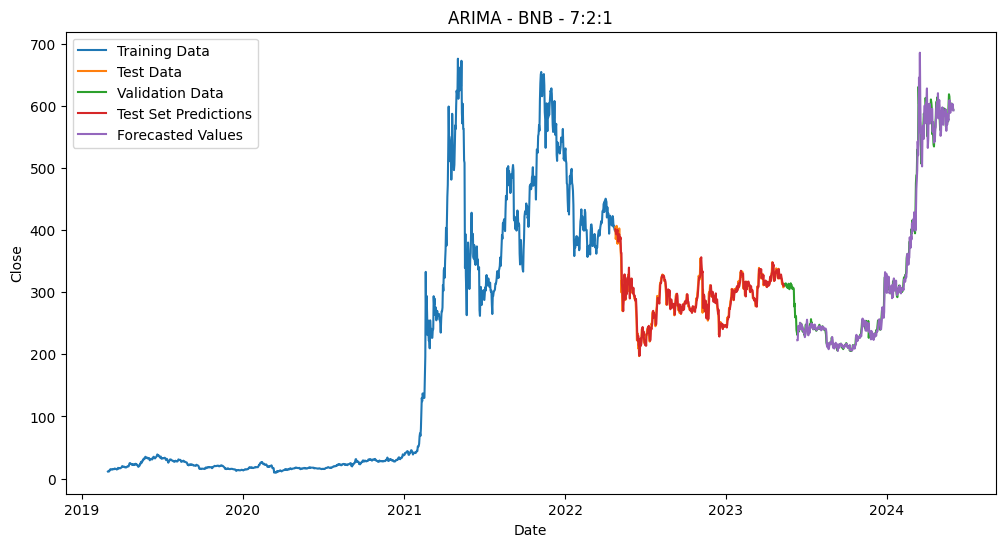

In [100]:
# Trực quan hóa kết quả
plt.figure(figsize=(12, 6))

# Plot train data
plt.plot(train_date_data, train_data, label='Training Data')
# Plot test data
plt.plot(test_date_data, test_data, label='Test Data')
# Plot validation data
plt.plot(val_date_data, val_data, label='Validation Data')
# Vẽ dự đoán trên tập kiểm tra
plt.plot(test_date_data,predictions,label='Test Set Predictions')
# Plot the forecasted values
plt.plot(forecasted_dates, forecasted_values, label='Forecasted Values')

plt.title('ARIMA - BNB - 7:2:1')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


In [ ]:
#30/40/90

#7. Tính

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'val_data' is the validation data series and 'last_date' is the last date of validation data.
# Define the sliding window ARIMA forecasting function
def sliding_window_arima(data, window_size, order, forecast_days):
    predictions = []
    for i in range(forecast_days):
        window_data = data[-window_size:]  # Take the last 'window_size' data points
        model = ARIMA(window_data, order=order)
        fit_model = model.fit()
        next_day_prediction = fit_model.forecast(steps=1)
        predictions.append(next_day_prediction)
        data = np.append(data, next_day_prediction)  # Update data with the forecasted value
    return np.array(predictions)

# Using the last 60 values of your validation data
window_size = 60
order = (4, 1, 4)

# Forecast for the next 30, 60, and 90 days
forecast_30 = sliding_window_arima(val_data[-window_size:], window_size, order, 30)
forecast_60 = sliding_window_arima(np.append(val_data[-window_size:], forecast_30), window_size, order, 60)
forecast_90 = sliding_window_arima(np.append(val_data[-window_size:], np.append(forecast_30, forecast_60)), window_size, order, 90)

# Create date ranges for the forecasts
last_date = val_date_data.iloc[-1]
dates_30 = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30)
dates_60 = pd.date_range(start=dates_30[-1] + pd.DateOffset(days=1), periods=60)
dates_90 = pd.date_range(start=dates_60[-1] + pd.DateOffset(days=1), periods=90)




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

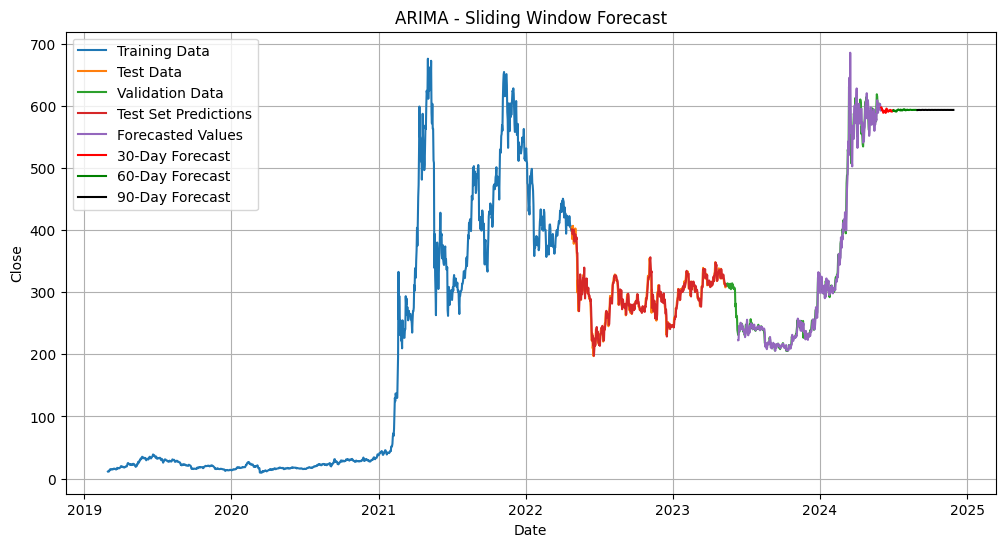

In [132]:
# Visualize the forecast results
plt.figure(figsize=(12, 6))
plt.plot(train_date_data, train_data, label='Training Data')
plt.plot(test_date_data, test_data, label='Test Data')
plt.plot(val_date_data, val_data, label='Validation Data')

# Vẽ dự đoán trên tập kiểm tra
plt.plot(test_date_data,predictions,label='Test Set Predictions')
# Plot the forecasted values
plt.plot(forecasted_dates, forecasted_values, label='Forecasted Values')

# Plot forecasted values
plt.plot(dates_30, forecast_30, label='30-Day Forecast', color='red')
plt.plot(dates_60, forecast_60, label='60-Day Forecast', color='green')
plt.plot(dates_90, forecast_90, label='90-Day Forecast', color='black')

plt.title('ARIMA - Sliding Window Forecast')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()